# Predictive Analytics - Individual Assignment

---

## 1. Project Framing & Setup

### Problem Definition

This project predicts **Seattle house prices** using property characteristics and crime data. The task is a **regression** problem: given features such as square footage, number of bedrooms, crime count within 1 km, and location, we predict the sale price.

### Success Metrics

- **RMSE** (Root Mean Squared Error): Dollar-value error; interpretable in the same units as price.
- **MAPE** (Mean Absolute Percentage Error): Percentage error; useful for comparing across different price ranges.

### Constraints

- **Interpretability:** Models should be explainable enough to understand which features drive price predictions.
- **Fairness:** Avoid reinforcing biases (e.g., crime proxies that may disparately affect certain neighborhoods).

### Agent Tooling Plan

Use the AI agent for boilerplate code (imports, plotting, data loading), but manually verify all spatial and temporal logic (boundary checks, date cutoffs, crime-count joins) to prevent leakage and geographic errors.

In [135]:
!pip install pandas numpy geopandas scipy matplotlib scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 37.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


### Environment Setup

Single cell with all imports and a check that required data files exist.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
from scipy.spatial import cKDTree

# Save figures as high-res PNGs
IMAGES_PATH = Path() / "images" / "predictive_analytics"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
plt.rc('font', size=14); plt.rc('axes', labelsize=14, titlesize=14); plt.rc('legend', fontsize=14); plt.rc('xtick', labelsize=10); plt.rc('ytick', labelsize=10)

# Check data files exist
for f in ['kingco_sales.csv', 'SPD_Crime_Data__2008-Present.csv', 'seattle_city_limits.geojson']:
    assert Path(f).exists(), f'Missing: {f}'
print('All data files found.')

All data files found.


---

## 2. Data Integration & Validation

### Unique Years in Each Dataset

In [138]:
# Date formats to avoid parsing warnings
KINGCO_DATE_FORMAT = '%Y-%m-%d'
SPD_DATE_FORMAT = '%m/%d/%Y %I:%M:%S %p'

# Load sales data - read only date column for efficiency (sales_temp is a temporary dataframe used only in this cell for the year analysis)
sales_temp = pd.read_csv('kingco_sales.csv', usecols=['sale_date'])
sales_temp['sale_date'] = pd.to_datetime(sales_temp['sale_date'], format=KINGCO_DATE_FORMAT, errors='coerce')
sales_temp['year'] = sales_temp['sale_date'].dt.year
sales_years = np.unique(sales_temp['year'].dropna()).astype(int).tolist()

# Count records per year
counts_per_year = sales_temp['year'].value_counts().sort_index()

print('kingco_sales.csv (sales_df)')
print(f'Unique years (sale_date): {sales_years}')
print(f'Year range: {min(sales_years)} - {max(sales_years)}')
print(f'\nRecords per year:')
print(counts_per_year.to_string())

kingco_sales.csv (sales_df)
Unique years (sale_date): [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Year range: 1999 - 2025

Records per year:
year
1999    24392
2000    22738
2001    21932
2002    23289
2003    28080
2004    31419
2005    32502
2006    29794
2007    23228
2008    14260
2009    12974
2010    13730
2011    12717
2012    16877
2013    21603
2014    22021
2015    25050
2016    26899
2017    27079
2018    23957
2019    24282
2020    26129
2021    30234
2022    21109
2023    15409
2024    17077
2025    16833


In [139]:
# Load crimes data - use chunks for large file
crimes_years_list = []
for chunk in pd.read_csv('SPD_Crime_Data__2008-Present.csv', chunksize=100000, usecols=['Offense Date'], low_memory=False):
    chunk['Offense Date'] = pd.to_datetime(chunk['Offense Date'], format=SPD_DATE_FORMAT, errors='coerce')
    chunk['year'] = chunk['Offense Date'].dt.year
    crimes_years_list.append(chunk['year'])

crimes_years_series = pd.concat(crimes_years_list)
counts_per_year_crimes = crimes_years_series.value_counts().sort_index()
crimes_years = np.unique(crimes_years_series.dropna()).astype(int).tolist()

print('SPD_Crime_Data__2008-Present.csv (crimes_df)')
print(f'Unique years (Offense Date): {crimes_years}')
print(f'Year range: {min(crimes_years)} - {max(crimes_years)}')
print(f'\nRecords per year:')
print(counts_per_year_crimes.to_string())

SPD_Crime_Data__2008-Present.csv (crimes_df)
Unique years (Offense Date): [1900, 1908, 1915, 1920, 1929, 1934, 1951, 1953, 1957, 1960, 1964, 1966, 1968, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Year range: 1900 - 2025

Records per year:
year
1900        5
1908        1
1915        1
1920        1
1929        1
1934        1
1951        1
1953        1
1957        1
1960        1
1964        4
1966        2
1968        1
1973        1
1974        3
1975        3
1976        5
1977        3
1978        1
1979        3
1980        7
1981        3
1982        1
1983        4
1984        2
1985        3
1986        1
1987        5
1988        3
1989        4
1990        6
1991       19
1992        4
1993       11
1994 

## Filter Data to Matching Years

Keep only records from 2021 onwards that appear in both datasets.

In [140]:
# Find years that appear in both datasets, from 2021 onwards
START_YEAR = 2021
matching_years = [y for y in np.intersect1d(sales_years, crimes_years) if y >= START_YEAR]
print(f'Matching years (from {START_YEAR}): {matching_years}')

# Filter sales data to matching years only
sales_raw = pd.read_csv('kingco_sales.csv')
sales_raw['sale_date'] = pd.to_datetime(sales_raw['sale_date'], format=KINGCO_DATE_FORMAT, errors='coerce')
sales_raw['sale_year'] = sales_raw['sale_date'].dt.year
sales_df = sales_raw[sales_raw['sale_year'].isin(matching_years)].copy()

# Filter crimes data to matching years only (load in chunks)
crimes_chunks = []
for chunk in pd.read_csv('SPD_Crime_Data__2008-Present.csv', chunksize=100000, low_memory=False):
    chunk['Offense Date'] = pd.to_datetime(chunk['Offense Date'], format=SPD_DATE_FORMAT, errors='coerce')
    chunk['year'] = chunk['Offense Date'].dt.year
    chunk_filtered = chunk[chunk['year'].isin(matching_years)]
    crimes_chunks.append(chunk_filtered)

crimes_df = pd.concat(crimes_chunks, ignore_index=True)

print(f'\nsales_df: {len(sales_df):,} rows')
print(f'crimes_df: {len(crimes_df):,} rows')

Matching years (from 2021): [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

sales_df: 100,662 rows
crimes_df: 360,496 rows


### Filter to Seattle City Limits (Point-in-Polygon)

Use official Seattle boundary (ArcGIS Open Data) with Point-in-Polygon for precise geographic filtering. Convex hull of boundary lines creates the polygon (lines don't form closed loops).

In [141]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union

# Load Seattle city limits (official boundary from ArcGIS Open Data)
# Source: https://opendata.arcgis.com/datasets/c5f3575dd7d545ada27064c74ac74f52
boundary_gdf = gpd.read_file('seattle_city_limits.geojson')

# Extract line segments (boundary is MultiLineString - lines don't form closed loops)
# Use convex hull to create polygon for Point-in-Polygon
all_lines = []
for geom in boundary_gdf.geometry:
    if geom.geom_type == 'MultiLineString':
        for line in geom.geoms:
            all_lines.append(line)
    elif geom.geom_type == 'LineString':
        all_lines.append(geom)

lines_union = unary_union(all_lines)
seattle_boundary = lines_union.convex_hull  # Polygon from boundary envelope

# Point-in-Polygon: keep only properties within Seattle boundary
sales_df['geometry'] = sales_df.apply(lambda r: Point(r['longitude'], r['latitude']), axis=1)
sales_gdf = gpd.GeoDataFrame(sales_df, geometry='geometry', crs='EPSG:4326')
in_seattle = sales_gdf.geometry.within(seattle_boundary)
# reset_index(drop=True): after filtering, indices are non-contiguous (e.g. 22777 rows but index 0..22801); reset gives clean 0-based indexing
sales_df = sales_df[in_seattle].drop(columns=['geometry']).reset_index(drop=True)

# crimes_df is already Seattle-only (SPD jurisdiction)
print(f'sales_df (Seattle only, PIP): {len(sales_df):,} rows')
print(f'crimes_df: {len(crimes_df):,} rows')

sales_df (Seattle only, PIP): 25,414 rows
crimes_df: 360,496 rows


**Agent Mistake and Correction:**

I initially asked the agents for help defining the study area. Gemini suggested joining the files and keeping only the coordinates present in the crime file. I realized this was a mistake because it would exclude Seattle neighborhoods with zero reported crimes, biasing the model. Cursor then suggested using a simple 'bounding box' (min/max lat/long). I rejected this as well because Seattle's borders are irregular; a rectangle would include neighboring cities. I corrected this by using an official GeoJSON polygon to ensure only Seattle-specific properties were retained.

## Check 2025 matching months/days

Ensure overlapping date coverage for Seattle data: use the earlier of the two max dates (crimes vs sales) minus 1 day as cutoff. Reproducible—no hardcoded dates.

**Spatial Join Logic:** Join properties with crime data by counting crimes within 1 km that occurred **before** the sale date (no look-ahead). Uses cKDTree for efficient spatial queries.

**Agent Mistake and Correction:**

During feature engineering, the agent's original approach was to count crimes within the same calendar year as the sale. I identified this as Look-ahead Bias. For a house sold in January 2024, the model would have 'seen' crimes from December 2024, which is information a buyer could not have had. I corrected the logic to strictly count only crimes that occurred before the specific sale date, ensuring the feature reflects the actual environment at the time of purchase.

In [142]:
# Dynamic end date: min of both max dates minus 1 day
max_crime_date = crimes_df['Offense Date'].max()
max_sales_date = sales_df['sale_date'].max()
END_DATE = (min(max_crime_date, max_sales_date) - pd.Timedelta(days=1)).normalize()
sales_df = sales_df[sales_df['sale_date'] <= END_DATE].copy()
crimes_df = crimes_df[crimes_df['Offense Date'] <= END_DATE].copy()

print(f'Max crime date (before cutoff): {max_crime_date}')
print(f'Max sales date (Seattle, before cutoff): {max_sales_date}')
print(f'END_DATE (min - 1 day): {END_DATE}')
print(f'\nsales_df: {len(sales_df):,} rows')
print(f'crimes_df: {len(crimes_df):,} rows')

Max crime date (before cutoff): 2025-05-25 00:11:00
Max sales date (Seattle, before cutoff): 2025-12-30 00:00:00
END_DATE (min - 1 day): 2025-05-24 00:00:00

sales_df: 22,803 rows
crimes_df: 360,445 rows


In [143]:
from scipy.spatial import cKDTree

# Filter valid coordinates (crimes_df uses -1.0 for missing; sales_df may have NaN)
sales_df = sales_df.dropna(subset=['latitude', 'longitude'])
RADIUS_KM = 1.0  # crimes within 1 km of property
# At Seattle latitude (~47°): 1° lat ≈ 111 km, 1° long ≈ 76 km
# 1 km ≈ 0.009° lat, 0.013° long - use 0.01 as approx for both
radius_deg = RADIUS_KM / 111

# Prepare crime data - valid coords only
crimes_df['Latitude'] = pd.to_numeric(crimes_df['Latitude'], errors='coerce')
crimes_df['Longitude'] = pd.to_numeric(crimes_df['Longitude'], errors='coerce')
crimes_valid = crimes_df[
    (crimes_df['Latitude'] > 40) & (crimes_df['Latitude'] < 50) &
    (crimes_df['Longitude'] < -100) & (crimes_df['Longitude'] > -125)
].copy()
crime_coords = crimes_valid[['Latitude', 'Longitude']].values
crime_dates = crimes_valid['Offense Date'].values  # datetime of each crime

# Build spatial index on crimes
crime_tree = cKDTree(crime_coords)

# Process in batches - vectorized query for speed
# crime_count_1km = count of crimes within 1km that occurred BEFORE sale date (no look-ahead)
# last_crime_date = date of most recent crime in count (NaT if none) — for date-level leakage proof
BATCH_SIZE = 50000
crime_counts = []
last_crime_dates = []
for i in range(0, len(sales_df), BATCH_SIZE):
    batch = sales_df.iloc[i:i+BATCH_SIZE]
    coords = batch[['latitude', 'longitude']].values
    sale_dates = batch['sale_date'].values
    all_indices = crime_tree.query_ball_point(coords, r=radius_deg)
    for j, inds in enumerate(all_indices):
        valid = [idx for idx in inds if crime_dates[idx] < sale_dates[j]]
        crime_counts.append(len(valid))
        last_crime_dates.append(max((crime_dates[idx] for idx in valid), default=pd.NaT))
    print(f'Processed {min(i+BATCH_SIZE, len(sales_df)):,} / {len(sales_df):,} properties...')

sales_df['crime_count_1km'] = crime_counts
sales_df['last_crime_date'] = last_crime_dates

# Create joined df (sales with crime feature)
df_joined = sales_df.copy()
print(f'\ndf_joined: {len(df_joined):,} rows')
print(f'Crime count stats: min={df_joined["crime_count_1km"].min()}, max={df_joined["crime_count_1km"].max()}, mean={df_joined["crime_count_1km"].mean():.1f}')

Processed 22,803 / 22,803 properties...

df_joined: 22,803 rows
Crime count stats: min=0, max=18126, mean=1232.7


---

## 3. Exploratory Data Analysis (EDA)

### Explore joined dataframe

## Data Wrangling: Column Definitions

Brief description of each column in `df_joined` (King County sales + Seattle crime):

| Column | Description |
|--------|-------------|
| **sale_id** | Unique identifier for the sale transaction |
| **pinx** | Parcel Identification Number (PIN) linking sale to assessor parcel record |
| **sale_date** | Date of the property sale |
| **sale_price** | Sale price (USD) |
| **sale_nbr** | Sale number (e.g., sale sequence when multiple per parcel) |
| **sale_warning** | Flag or note about the sale (e.g., data quality) |
| **join_status** | How the sale was joined to the property record (e.g., demo, full) |
| **join_year** | Year used when joining sale to property data |
| **latitude**, **longitude** | Property coordinates (WGS84) |
| **area** | Assessor area code |
| **city** | City or jurisdiction (e.g., SEATTLE, KING COUNTY) |
| **zoning** | Zoning designation (e.g., SF 5000, RA2.5P) |
| **subdivision** | Subdivision or plat name |
| **present_use** | Present use code (residential, commercial, etc.) |
| **land_val** | Assessed land value (USD) |
| **imp_val** | Assessed improvement (building) value (USD) |
| **year_built** | Year the structure was built |
| **year_reno** | Year of last major renovation (0 if none) |
| **sqft_lot** | Lot area (sq ft) |
| **sqft** | Total living area (sq ft) |
| **sqft_1** | Living area above grade (sq ft) |
| **sqft_fbsmt** | Finished basement area (sq ft) |
| **grade** | Construction quality grade (assessor scale) |
| **fbsmt_grade** | Finished basement grade |
| **condition** | Physical condition rating |
| **stories** | Number of stories |
| **beds** | Number of bedrooms |
| **bath_full**, **bath_3qtr**, **bath_half** | Full, 3/4, and half bathrooms |
| **garb_sqft**, **gara_sqft** | Garage and carport area (sq ft) |
| **wfnt**, **golf**, **greenbelt** | Waterfront, golf, greenbelt indicators |
| **noise_traffic** | Traffic noise factor |
| **view_rainier**, **view_olympics**, **view_cascades**, etc. | View quality scores (mountain, water, skyline, etc.) |
| **submarket** | Submarket code (geographic market area) |
| **sale_year** | Year of sale (derived from sale_date) |
| **crime_count_1km** | Count of crimes within 1 km that occurred before the sale date |
| **last_crime_date** | Date of most recent crime in count (NaT if none); for date-level leakage verification |

In [144]:
# Shape and columns
print(f'Shape: {df_joined.shape[0]:,} rows × {df_joined.shape[1]} columns')
print(f'\nColumns: {list(df_joined.columns)}')

# Preview
print('\n--- First 5 rows ---')
display(df_joined.head())

# Summary stats for key columns
print('\n--- Summary (sale_price, crime_count_1km) ---')
display(df_joined[['sale_price', 'crime_count_1km']].describe())

Shape: 22,803 rows × 51 columns

Columns: ['sale_id', 'pinx', 'sale_date', 'sale_price', 'sale_nbr', 'sale_warning', 'join_status', 'join_year', 'latitude', 'longitude', 'area', 'city', 'zoning', 'subdivision', 'present_use', 'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other', 'submarket', 'sale_year', 'crime_count_1km', 'last_crime_date']

--- First 5 rows ---


,sale_id,pinx,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,...,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket,sale_year,crime_count_1km,last_crime_date
0,2021..83,..8068000470,2021-01-06,835000,2.0,,demo,1999,47.509428,-122.262360,...,2,0,3,0,0,0,J,2021,11,2021-01-04 20:22:00
1,2021..213,..1797501055,2021-01-06,1160000,2.0,,demo,1999,47.671540,-122.316518,...,0,0,0,0,0,0,C,2021,32,2021-01-05 18:05:00
2,2021..230,..7258200025,2021-01-06,550000,6.0,,demo,1999,47.514482,-122.316798,...,0,0,0,0,0,0,J,2021,1,2021-01-04 02:24:00
3,2021..350,..8615800035,2021-01-08,1307000,5.0,,demo,1999,47.669308,-122.311003,...,0,0,0,0,0,0,C,2021,49,2021-01-07 22:16:00
4,2021..626,..6096000380,2021-01-08,1895000,3.0,,demo,1999,47.631176,-122.350439,...,3,0,0,0,0,0,D,2021,22,2021-01-07 11:30:00



--- Summary (sale_price, crime_count_1km) ---


,sale_price,crime_count_1km
count,2.280300e+04,22803.000000
mean,1.053249e+06,1232.732754
std,6.409291e+05,1501.250643
min,1.500000e+05,0.000000
25%,7.000000e+05,270.000000
50%,8.750000e+05,734.000000
75%,1.200000e+06,1641.000000
max,1.700000e+07,18126.000000


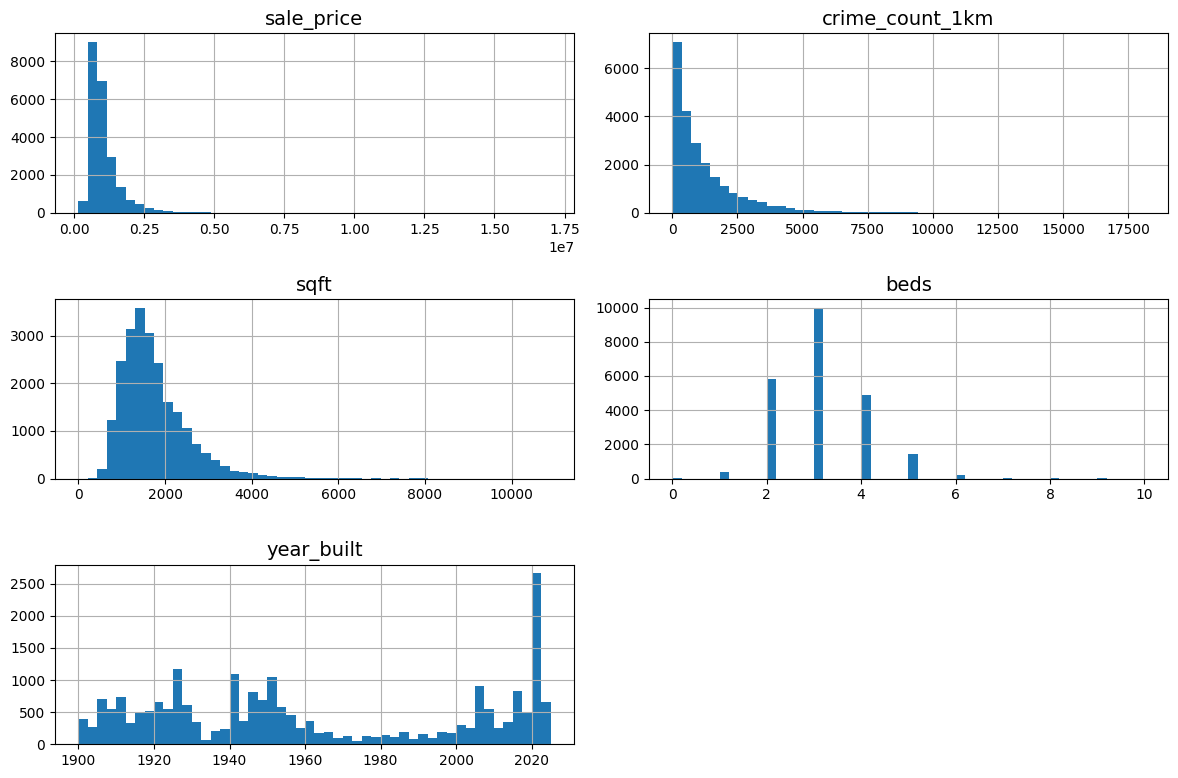

In [145]:
# Histograms of key numeric attributes
df_joined[['sale_price', 'crime_count_1km', 'sqft', 'beds', 'year_built']].hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")
plt.show()

**Observation:** crime_count_1km shows weak correlation with sale_price; a log transform or regression with controls may reveal stronger effects.

### Visualizations

#### Correlation Heatmap

### Log crime variable

Pearson correlation assumes linearity. Crime may relate to price in a log-linear way. We add `log(1 + crime_count_1km)` and compare its correlation with price.

**Interpretation:** Both correlations are very weak (~±0.03). This does *not* mean crime is irrelevant:

- **Bivariate vs. multivariate:** Correlation ignores other predictors. In a regression controlling for sqft, location (lat/lon), grade, etc., crime may still have a significant coefficient.
- **Location absorbs crime:** Crime and price both vary by neighborhood. Latitude/longitude may capture most of the geographic signal, leaving little "left over" for crime in a simple correlation.
- **Non-linear or threshold effects:** Pearson assumes a straight line. The decile boxplot or sqft×crime scatter may show effects that correlation misses.

**Next step:** Run a regression model with crime (raw or log) alongside other features to assess its marginal effect.

In [146]:
# Log crime: log(1 + x) handles zeros and compresses the long tail
df_joined['log_crime_1km'] = np.log1p(df_joined['crime_count_1km'])

# Compare correlations with sale_price
r_raw = df_joined['crime_count_1km'].corr(df_joined['sale_price'])
r_log = df_joined['log_crime_1km'].corr(df_joined['sale_price'])
print(f'Correlation with sale_price:')
print(f'  crime_count_1km:  {r_raw:.4f}')
print(f'  log(1+crime_1km): {r_log:.4f}')
print(f'  → Log transform {"stronger" if abs(r_log) > abs(r_raw) else "weaker"} correlation')

Correlation with sale_price:
  crime_count_1km:  -0.0235
  log(1+crime_1km): 0.0299
  → Log transform stronger correlation


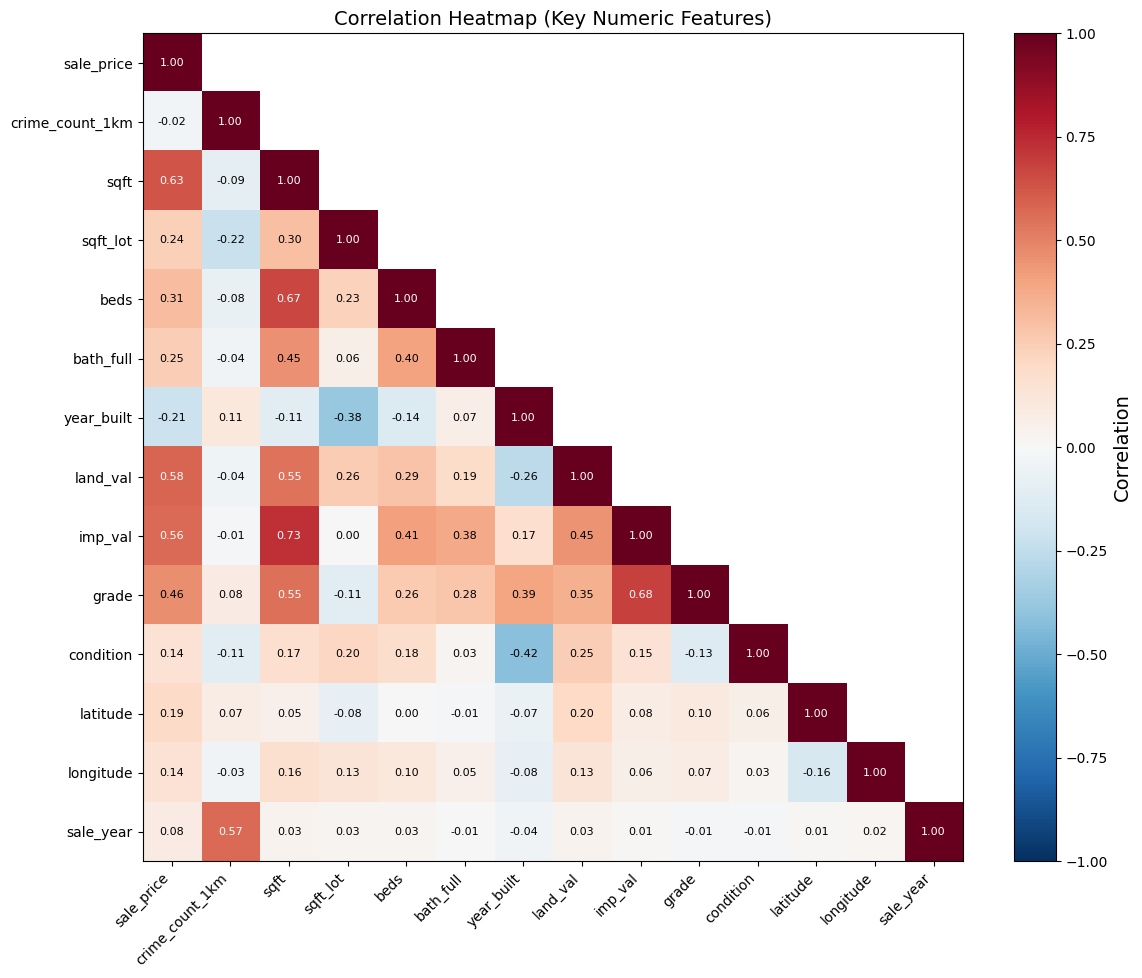

In [147]:
# Select key numeric columns for correlation (exclude IDs, dates)
num_cols = ['sale_price', 'crime_count_1km', 'sqft', 'sqft_lot', 'beds', 'bath_full', 'year_built',
            'land_val', 'imp_val', 'grade', 'condition', 'latitude', 'longitude', 'sale_year']
corr_df = df_joined[[c for c in num_cols if c in df_joined.columns]].corr()

# Mask upper triangle for half heatmap
mask = np.triu(np.ones_like(corr_df, dtype=bool), k=1)  # k=1 excludes diagonal from mask
corr_masked = corr_df.copy()
corr_masked = corr_masked.astype(float)
corr_masked[mask] = np.nan

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_masked, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(corr_df.columns)))
ax.set_yticks(range(len(corr_df.columns)))
ax.set_xticklabels(corr_df.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_df.columns)

# Add correlation coefficients in each cell (lower triangle only)
for i in range(len(corr_df)):
    for j in range(len(corr_df)):
        if not mask[i, j]:  # lower triangle or diagonal
            val = corr_df.iloc[i, j]
            color = 'white' if abs(val) > 0.5 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color=color)

plt.colorbar(im, ax=ax, label='Correlation')
plt.title('Correlation Heatmap (Key Numeric Features)')
save_fig("correlation_heatmap")
plt.tight_layout()
plt.show()

#### Crime Decile Boxplots

Pearson correlation assumes linearity. Crime may have a threshold effect.

**Observation:** Look for a "cliff" where price drops only after crime hits a certain decile.

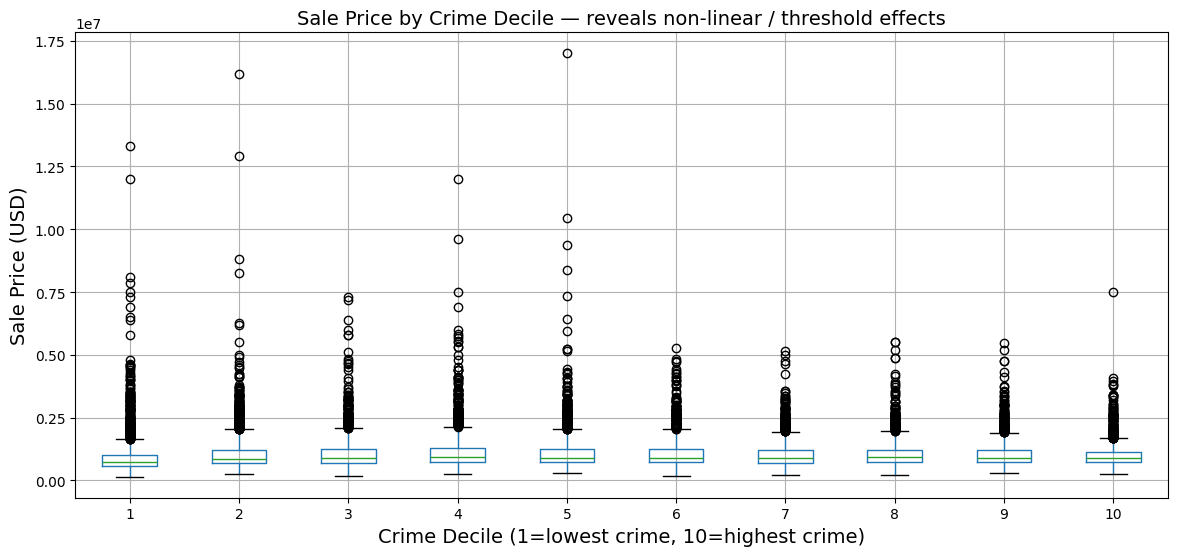

In [148]:
# Crime deciles: split crime_count_1km into 10 groups (lowest to highest)
df_joined['crime_decile'] = pd.qcut(df_joined['crime_count_1km'], q=10, labels=False, duplicates='drop') + 1

# Boxplot: sale_price by crime decile
fig, ax = plt.subplots(figsize=(12, 6))
df_joined.boxplot(column='sale_price', by='crime_decile', ax=ax)
ax.set_xlabel('Crime Decile (1=lowest crime, 10=highest crime)')
ax.set_ylabel('Sale Price (USD)')
ax.set_title('Sale Price by Crime Decile — reveals non-linear / threshold effects')
plt.suptitle('')  # remove default "Boxplot grouped by crime_decile"
save_fig("sale_price_by_crime_decile")
plt.tight_layout()
plt.show()

## The "Grade" Interaction: sqft vs. Price, Colored by Crime

For the same size house (sqft), do high-crime areas sell for less? Dots colored by `crime_count_1km` — darker/redder = higher crime. Look for high-crime dots (darker) consistently at the bottom of the price range for each sqft band.

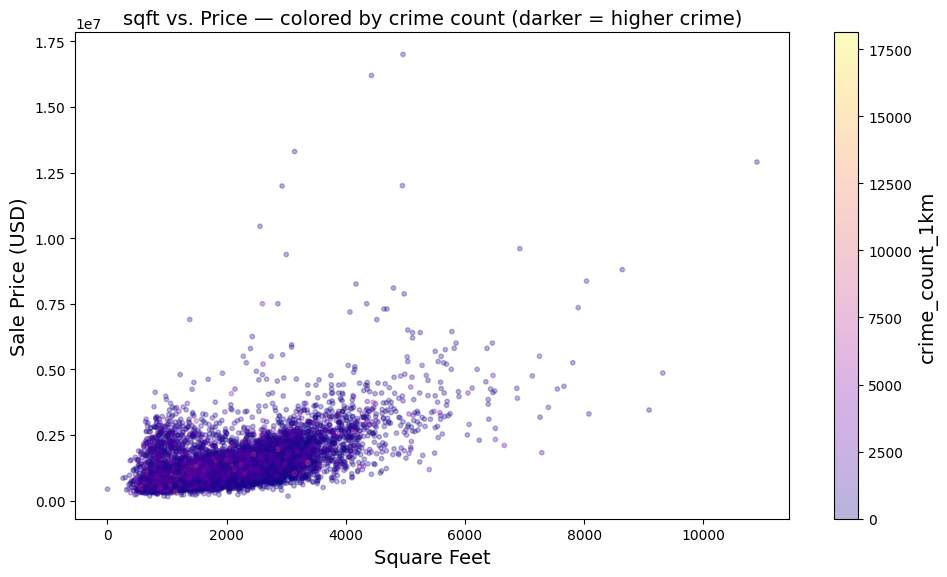

In [149]:
# Scatter: sqft vs sale_price, colored by crime_count_1km (darker = higher crime)
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(df_joined['sqft'], df_joined['sale_price'], c=df_joined['crime_count_1km'],
                cmap='plasma', alpha=0.3, s=10)
ax.set_xlabel('Square Feet')
ax.set_ylabel('Sale Price (USD)')
ax.set_title('sqft vs. Price — colored by crime count (darker = higher crime)')
plt.colorbar(sc, ax=ax, label='crime_count_1km')
save_fig("sqft_price_colored_by_crime")
plt.tight_layout()
plt.show()

#### Target Distribution

**Observation:** The price distribution is right-skewed; I will implement a Log Transformation in the pipeline.

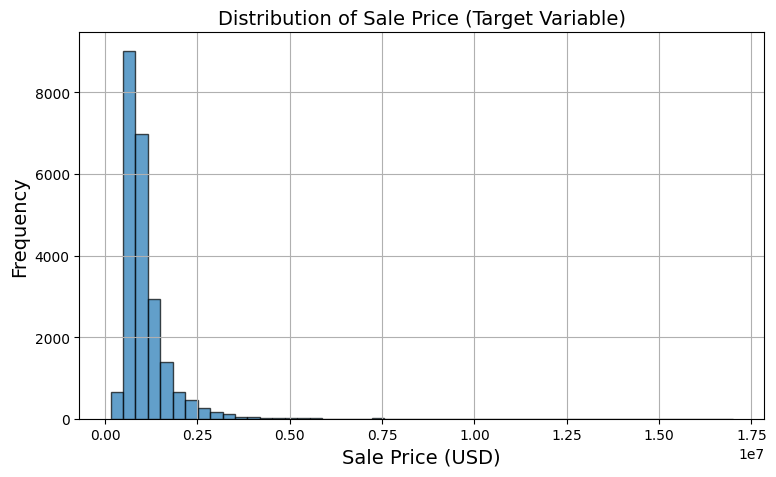

In [150]:
# sale_price histogram — shows long tail to the right (very expensive properties)
df_joined['sale_price'].hist(bins=50, figsize=(8, 5), edgecolor='black', alpha=0.7)
plt.xlabel('Sale Price (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Price (Target Variable)')
save_fig("sale_price_histogram")
plt.show()

### Validation Checks

**Leakage check:** No future crimes—every crime in `crime_count_1km` occurred before the sale date. We check `last_crime_date < sale_date` at the date level (not just year).

In [151]:
# Leakage proof: last_crime_date must be < sale_date
# Rows with no crimes (last_crime_date=NaT) are fine; NaT < date is False, so we exclude them
has_crimes = df_joined['crime_count_1km'] > 0
leakage = (has_crimes & (df_joined['last_crime_date'] >= df_joined['sale_date'])).sum()
print(f"Rows with last_crime_date >= sale_date (leakage): {leakage}")
assert leakage == 0, "Leakage detected! Some crimes may be from on or after the sale date."
print("✓ Time-aware join verified: no future information in crime counts (year, month, day).")

Rows with last_crime_date >= sale_date (leakage): 0
✓ Time-aware join verified: no future information in crime counts (year, month, day).


**Boundary verification:** All properties are within the Seattle PIP boundary.

In [152]:
# Boundary verification: coordinates within Seattle
min_lat = df_joined['latitude'].min()
max_lat = df_joined['latitude'].max()
min_lon = df_joined['longitude'].min()
max_lon = df_joined['longitude'].max()
print(f"Latitude:  min ≈ {min_lat:.2f}, max ≈ {max_lat:.2f}")
print(f"Longitude: min ≈ {min_lon:.2f}, max ≈ {max_lon:.2f}")
print(f"Records: {len(df_joined):,}")
print("\nGeographic validation confirmed all records reside within Seattle city limits.")

Latitude:  min ≈ 47.50, max ≈ 47.73
Longitude: min ≈ -122.38, max ≈ -122.24
Records: 22,803

Geographic validation confirmed all records reside within Seattle city limits.


In [153]:
df_joined.info()

<class 'pandas.DataFrame'>
Index: 22803 entries, 0 to 25306
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sale_id           22803 non-null  str           
 1   pinx              22803 non-null  str           
 2   sale_date         22803 non-null  datetime64[us]
 3   sale_price        22803 non-null  int64         
 4   sale_nbr          16683 non-null  float64       
 5   sale_warning      22803 non-null  str           
 6   join_status       22803 non-null  str           
 7   join_year         22803 non-null  int64         
 8   latitude          22803 non-null  float64       
 9   longitude         22803 non-null  float64       
 10  area              22803 non-null  int64         
 11  city              22803 non-null  str           
 12  zoning            22803 non-null  str           
 13  subdivision       21695 non-null  str           
 14  present_use       22803 non-null  int6

### Data Quality Issues

- **Outliers:** sale_price and crime_count_1km have long right tails; consider winsorization or log transform.
- **Multicollinearity:** `sqft` (total living area) and `sqft_1` (living area above grade) are highly correlated; consider dropping one or using VIF to decide.

In [154]:
df_joined["sale_year"].value_counts()

sale_year
2021    7930
2022    5321
2024    4038
2023    3824
2025    1690
Name: count, dtype: int64